## SEP 740 Project Report - Group 9

In [ ]:
#Preprocessing the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import time
import re
import nltk.corpus
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.layers import MaxPooling1D,Conv1D,Dense,Flatten,ReLU,Dropout,Flatten
from keras import layers
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model,Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split



from keras.optimizers import Adam
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
url = 'https://raw.githubusercontent.com/dashascience/-MBTI-Myers-Briggs-Personality-Type-Dataset/master/mbti_1.csv'
df = pd.read_csv(url)

In [ ]:
# normalize, remove stop words and url links.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
clean_text1=[]
for i in df.posts[0].split('|||'):
  i=i.lower()
  i = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
  i_tokens = word_tokenize(i)
  filtered_i = [w for w in i_tokens if not w in stop_words]
  clean_text1.append(filtered_i)

In [ ]:
#lemmatization ensure that only words that mean similar things are consolidated into a single token
for j in clean_text1:
  for p in range(len(j)):
    j[p]=lemmatizer.lemmatize(j[p])


In [ ]:
# Clean methods for dataframe cleaning
def clean_data(str):
  clean_text1=[]
  for i in str.split('|||'):
    i=i.lower()
    i = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
    i_tokens = word_tokenize(i)
    filtered_i = [w for w in i_tokens if not w in stop_words]
    clean_text1.append(filtered_i)
  return clean_text1

def lemmatized_data(strList):
  for j in strList:
    for p in range(len(j)):
      j[p]=lemmatizer.lemmatize(j[p])
  return strList

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
#MBTI related words
mbti = ["intj","intp","infj", "infp","istj","istp","isfj","isfp","entj","entp", "enfj", "enfp","estj", "estp","esfj","esfp","si","ni","ti","fi","se",
        "ne","te","fe","nt","nf","le","mbti","sp","sj","sf","st","in","is","en","es"]
data_length=[]
lemmatizer=WordNetLemmatizer()
clean_text1=[]
for i in range(0,len(df.posts)):
  doc = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", df.posts[i])
  doc = doc.lower()
  doc = doc.split()
  #Remove MBTI related words and lemmatize the rest words
  for w in doc:
    if w in mbti:
      doc.remove(w)
    elif not w in set(stopwords):
        lemmatizer.lemmatize(w) 

      
  doc = ' '.join(doc)
  clean_text1.append(doc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
types = np.unique(df.type.values)

def get_type_index(string):
    return list(types).index(string)

df['type_index'] = df['type'].apply(get_type_index)
# Find the original posts column
n = df.columns[1]
# Drop that column
df.drop(n, axis = 1, inplace = True)
# Put cleaned posts in place
df[n] = clean_text1

In [ ]:
#specify the amount of features
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df.posts)

import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=39) # fit predictor and target variable


maxlen = 500
#Transform text into sequence and pad posts with size of 500
train_sequences = tokenizer.texts_to_sequences(df.posts.values)
train_padded = pad_sequences(train_sequences, maxlen = maxlen)
labels= tf.keras.utils.to_categorical(df.type_index.values, num_classes=16)
x_rus, y_rus = ros.fit_resample(train_padded, labels)

x_train,x_test,y_train,y_test=train_test_split(x_rus, y_rus, test_size=0.2, random_state=42)

x_train,x_val,y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=39) 


#Transform text into sequence and pad posts with size of 500 for validation set
#Show shapes of different sets                            
print("Training set shape:",x_train.shape)
print("Vlidation set shape:",x_val.shape)
print("Testing set shape:",x_test.shape)

Training set shape: (19931, 500)
Vlidation set shape: (3518, 500)
Testing set shape: (5863, 500)


In [ ]:
#Define model 
def create_model_CNN(lrn_rate,drop_rate):
    model = Sequential()
    model.add(Embedding(vocab_size,64,input_length=len(train_padded[0])))

    model.add(Conv1D(64,5,activation = "relu"))
    model.add(Dropout(drop_rate))
    model.add(MaxPooling1D())

    model.add(Conv1D(64,5,activation = "relu"))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate=lrn_rate), metrics=['accuracy'])
    return model

In [ ]:
#Build model with fine-tuned hyper-parameters
#‘batch_size': 350, 'drop_rate': 0.1, 'epochs': 40, 'lrn_rate': 0.001
model = create_model_CNN(0.001,0.1)
history = model.fit(x_train,y_train, batch_size = 350,epochs = 40, verbose = 1, validation_data = (x_val, y_val))
hist = pd.DataFrame(history.history)

Epoch 1/40
57/57 [==============================] - 11s 39ms/step - loss: 2.4128 - accuracy: 0.2759 - val_loss: 1.7451 - val_accuracy: 0.4764
Epoch 2/40
57/57 [==============================] - 2s 30ms/step - loss: 1.2027 - accuracy: 0.6529 - val_loss: 0.9057 - val_accuracy: 0.7382
Epoch 3/40
57/57 [==============================] - 2s 30ms/step - loss: 0.5695 - accuracy: 0.8305 - val_loss: 0.5997 - val_accuracy: 0.8110
Epoch 4/40
57/57 [==============================] - 2s 31ms/step - loss: 0.2714 - accuracy: 0.9233 - val_loss: 0.5327 - val_accuracy: 0.8380
Epoch 5/40
57/57 [==============================] - 2s 30ms/step - loss: 0.1435 - accuracy: 0.9637 - val_loss: 0.4856 - val_accuracy: 0.8547
Epoch 6/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0639 - accuracy: 0.9878 - val_loss: 0.5312 - val_accuracy: 0.8488
Epoch 7/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0353 - accuracy: 0.9949 - val_loss: 0.5872 - val_accuracy: 0.8613
Epoch 8/40
5

In [ ]:
#Print out training and validation process
print(hist)

        loss  accuracy  val_loss  val_accuracy
0   2.412793  0.275852  1.745052      0.476407
1   1.202710  0.652852  0.905726      0.738204
2   0.569517  0.830465  0.599698      0.810972
3   0.271353  0.923285  0.532677      0.837976
4   0.143483  0.963725  0.485649      0.854747
5   0.063941  0.987758  0.531184      0.848778
6   0.035344  0.994882  0.587180      0.861285
7   0.024719  0.996689  0.597529      0.846788
8   0.019284  0.997090  0.602654      0.859579
9   0.015502  0.997542  0.610433      0.859295
10  0.015225  0.997491  0.659313      0.847072
11  0.010148  0.998796  0.651197      0.855600
12  0.008588  0.998946  0.672511      0.855316
13  0.007995  0.998997  0.716552      0.849062
14  0.006115  0.999147  0.725305      0.849915
15  0.005708  0.999197  0.711366      0.853326
16  0.005266  0.999398  0.709810      0.853894
17  0.004306  0.999548  0.765328      0.855600
18  0.004866  0.999348  0.735169      0.854178
19  0.005520  0.998896  0.779457      0.857021
20  0.004473 

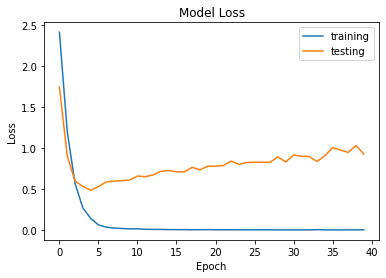

In [ ]:
#Plot the loss cureve for training and validation set
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='upper right')
plt.show()

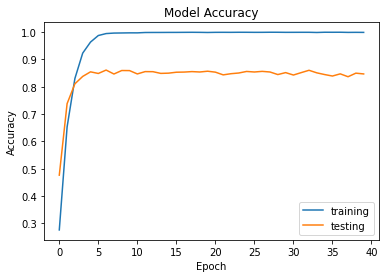

In [ ]:
#Plot the accuracy cureve for training and validation set
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='testing')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.show()

In [ ]:
#Use the model to predict results for the test sets
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

#Get detailed reuslt
train_probs = model.predict(x_test)
#Tranform the format of the results into labels of types
train_preds = tf.argmax(train_probs, axis=1)
result_list = []
#Create a result list
for i in train_preds:
  value = tf.constant(i)
  value = value.numpy()
  result_list.append(value)
print(result_list)


184/184 - 1s - loss: 0.9690 - accuracy: 0.8450 - 701ms/epoch - 4ms/step
Test Loss 0.9690312147140503
Test Accuracy 0.8449599146842957
184/184 [==============================] - 0s 2ms/step
[6, 14, 7, 2, 4, 11, 2, 15, 0, 12, 5, 10, 4, 11, 0, 2, 1, 10, 8, 4, 13, 4, 3, 2, 8, 7, 12, 12, 7, 3, 0, 1, 1, 4, 6, 9, 12, 10, 4, 15, 9, 10, 4, 12, 3, 11, 8, 15, 14, 7, 0, 4, 0, 7, 1, 2, 2, 14, 4, 11, 13, 9, 10, 7, 0, 5, 9, 2, 2, 15, 7, 3, 7, 12, 6, 13, 1, 11, 6, 7, 4, 1, 0, 7, 5, 15, 9, 2, 3, 11, 8, 10, 13, 0, 12, 11, 4, 5, 5, 12, 9, 1, 11, 9, 12, 2, 10, 14, 2, 2, 0, 8, 2, 7, 13, 12, 2, 11, 6, 0, 14, 13, 6, 8, 1, 8, 10, 15, 15, 3, 10, 12, 15, 4, 6, 0, 2, 0, 2, 7, 13, 10, 4, 12, 11, 1, 1, 7, 5, 0, 10, 11, 0, 11, 0, 0, 8, 4, 14, 8, 2, 2, 10, 11, 3, 7, 13, 7, 9, 4, 3, 12, 0, 7, 9, 3, 5, 15, 15, 11, 5, 5, 13, 1, 3, 3, 0, 0, 12, 1, 4, 15, 0, 13, 4, 6, 6, 4, 6, 11, 8, 11, 13, 4, 11, 9, 11, 1, 2, 4, 10, 13, 11, 11, 1, 11, 4, 8, 14, 15, 14, 13, 5, 1, 14, 12, 4, 15, 8, 6, 15, 4, 8, 8, 15, 13, 5, 7, 2, 4, 4, 

In [ ]:
#Define the batch size
accu_batch = 40

accu_curve_list = []
loss_curve_list = []
y_test = np.argmax(y_test, axis=1)
non_count = 0

#Calculate the accuracy and the loss for each batch and stores into lists
#Accuracy = number of correct prediction / number of test cases in the batch
#loss = number of wrong prediction / number of test cases in the batch
for i in range(0,len(result_list),accu_batch):
  st = i
  end = i + accu_batch
  print('Batch from:'+ str(st) +' to ' + str(end))
  accu_num = 0
  false_num = 0
  for y in range(st,end):
    if y < len(result_list):
      if (result_list[y] == y_test[y]): 
        accu_num = accu_num + 1
      else:  
        false_num = false_num + 1
    else:
      non_count = non_count + 1

  print(accu_num,false_num)
  if y < len(result_list):
    accu_curve_list.append(accu_num/accu_batch)
    loss_curve_list.append(false_num/accu_batch)
  else: 
    accu_curve_list.append(accu_num/(accu_batch-non_count))
    loss_curve_list.append(false_num/(accu_batch-non_count))

Batch from:0 to 40
38 2
Batch from:40 to 80
35 5
Batch from:80 to 120
30 10
Batch from:120 to 160
33 7
Batch from:160 to 200
33 7
Batch from:200 to 240
32 8
Batch from:240 to 280
36 4
Batch from:280 to 320
32 8
Batch from:320 to 360
32 8
Batch from:360 to 400
37 3
Batch from:400 to 440
34 6
Batch from:440 to 480
34 6
Batch from:480 to 520
30 10
Batch from:520 to 560
32 8
Batch from:560 to 600
33 7
Batch from:600 to 640
34 6
Batch from:640 to 680
34 6
Batch from:680 to 720
35 5
Batch from:720 to 760
34 6
Batch from:760 to 800
40 0
Batch from:800 to 840
33 7
Batch from:840 to 880
35 5
Batch from:880 to 920
35 5
Batch from:920 to 960
34 6
Batch from:960 to 1000
32 8
Batch from:1000 to 1040
35 5
Batch from:1040 to 1080
32 8
Batch from:1080 to 1120
34 6
Batch from:1120 to 1160
36 4
Batch from:1160 to 1200
37 3
Batch from:1200 to 1240
35 5
Batch from:1240 to 1280
34 6
Batch from:1280 to 1320
35 5
Batch from:1320 to 1360
35 5
Batch from:1360 to 1400
35 5
Batch from:1400 to 1440
33 7
Batch fro

In [ ]:
print('Number of batches: ',len(accu_curve_list))
print(accu_curve_list)
print(loss_curve_list)

Number of batches:  147
[0.95, 0.875, 0.75, 0.825, 0.825, 0.8, 0.9, 0.8, 0.8, 0.925, 0.85, 0.85, 0.75, 0.8, 0.825, 0.85, 0.85, 0.875, 0.85, 1.0, 0.825, 0.875, 0.875, 0.85, 0.8, 0.875, 0.8, 0.85, 0.9, 0.925, 0.875, 0.85, 0.875, 0.875, 0.875, 0.825, 0.825, 0.85, 0.8, 0.875, 0.875, 0.775, 0.875, 0.85, 1.0, 0.85, 0.675, 0.85, 0.9, 0.825, 0.9, 0.925, 0.9, 0.775, 0.825, 0.825, 0.75, 0.9, 0.825, 0.85, 0.875, 0.8, 0.825, 0.8, 0.875, 0.8, 0.85, 0.875, 0.8, 0.925, 0.9, 0.8, 0.8, 0.85, 0.875, 0.85, 0.85, 0.8, 0.8, 0.8, 0.8, 0.8, 0.875, 0.85, 0.95, 0.8, 0.825, 0.8, 0.975, 0.925, 0.775, 0.9, 0.8, 0.925, 0.775, 0.75, 0.825, 0.8, 0.775, 0.9, 0.9, 0.8, 0.9, 0.825, 0.775, 0.85, 0.875, 0.75, 0.875, 0.925, 0.75, 0.9, 0.875, 0.9, 0.875, 0.925, 0.85, 0.775, 0.85, 0.875, 0.875, 0.8, 0.9, 0.95, 0.825, 0.75, 0.925, 0.725, 0.825, 0.85, 0.75, 0.85, 0.8, 0.85, 0.825, 0.85, 0.9, 0.875, 0.825, 0.8, 0.825, 0.85, 0.825, 0.825, 0.85, 0.9, 0.6956521739130435]
[0.05, 0.125, 0.25, 0.175, 0.175, 0.2, 0.1, 0.2, 0.2, 0.075

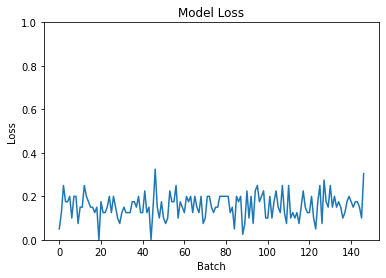

In [ ]:
#Draw the loss curve for the test set 
plt.plot(loss_curve_list)
plt.rcParams["figure.figsize"] = (15,3)
plt.title('Model Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
bottom,top = plt.ylim()
plt.ylim(0,1)

plt.show()

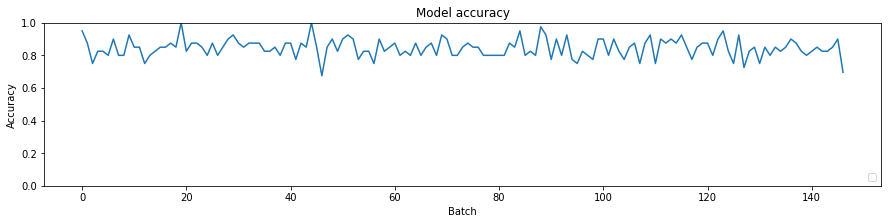

In [ ]:
#Draw the accuracy curve for the test set 
plt.plot(accu_curve_list)
plt.title('Model accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
bottom,top = plt.ylim()
plt.ylim(0,1)
plt.rcParams["figure.figsize"] = (3,15)
plt.show()